# RAG Agent Based on LangChain and LangGraph

This is the version to showcase.

This notebook demonstrates an intelligent agentic workflow that can process multiple documents, answer questions, measure retrieval quality, trace key message exchanges and costs, and keep a logging system for future reference at thread level.

It consumes job description and applicant documents and can help decide whether the applicant is a good fit for the positionm, which can be transferred to many use case such as if the claim is eligible for some policies.


# First, set up environments.

In [1]:
import os
import pandas as pd

from datetime import datetime
from dotenv import load_dotenv
from json import loads, dumps
from langchain.tools.retriever import create_retriever_tool

from pydantic import BaseModel, Field
from typing import Annotated, Sequence, TypedDict, Literal

from IPython.display import Image, display

from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFLoader

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter, RecursiveJsonSplitter

from langfuse import Langfuse, get_client
from langfuse.langchain import CallbackHandler
from langfuse.openai import openai  # Don't delete this line.

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode

C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set up environment variables.
load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')

# Monitor if the environment variables are ready.
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set - please head to the troubleshooting guide in the setup folder")

OpenAI API Key exists and begins sk-proj-


In [3]:
langfuse_secret_key = os.getenv('LANGFUSE_SECRET_KEY')
langfuse_public_key = os.getenv('LANGFUSE_PUBLIC_KEY')
langfuse = Langfuse(
    secret_key = langfuse_secret_key,
    public_key = langfuse_public_key,
    host="https://cloud.langfuse.com"
    # host = "https://us.cloud.langfuse.com"
)

langfuse = get_client()
 
# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

Langfuse client is authenticated and ready!


In [4]:
CONFIG = {
    "vector_store_directory": "./chroma_db",
    "vector_store_collection_name": "langchain_rag",
    "chunk_size": 500,
    "chunk_overlap": 50
}

# Second, set up Retriever with ChromaDB.

In [5]:
# Initialise or call existing vector store ChromaDB.
embeddings =OpenAIEmbeddings()
vector_store = Chroma(
    collection_name=CONFIG["vector_store_collection_name"],
    embedding_function=embeddings,
    persist_directory=CONFIG["vector_store_directory"],
)

# Since this is a small project, use small chunk size.
text_splitter = RecursiveCharacterTextSplitter(
        chunk_size = CONFIG["chunk_size"],
        chunk_overlap = CONFIG["chunk_overlap"]
    )

In [6]:
def import_job_advertisement_documents(vector_store, file_path, text_splitter, doc_id):
    """
    Consume pdf documents into specific vector store with version control.

    Args:
        vector_store: The current vector store
        file_path: The path to pdf documents
        text_splitter: The current text splitter.
        doc_id: The metadata that will be used for version control.

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    llm_outputs_df = pd.read_csv(file_path)
    llm_json = llm_outputs_df[['job_title', 'skills', 'responsibilities', 'requirements',
       'classification', 'salary', 'location', 'workType']].apply(lambda row: dumps(row.to_dict()), axis=1).tolist()
    docs = text_splitter.create_documents(llm_json)
    
    for doc in docs:
        doc.metadata = {
            "text": doc.page_content,
            "doc_id": doc_id,
        }

    # Before add the chunks into vector store, ensure the old version are dropped.
    vector_store._collection.delete(where={"doc_id": doc_id})
    vector_store.add_documents(docs)

    # Print basic information of cosumed documents in the vector store.
    stored_documents = vector_store.get(
        ids=None,  
        where={"doc_id": doc_id},  
        limit=None,  
        offset=None,  
        include=['documents', 'metadatas', 'embeddings']  
    )

    """
    # Print more detailed information if needed.
    for i, doc_content in enumerate(stored_documents['documents']):
        print(f"Document ID: {stored_documents['ids'][i]}")
        print(f"Document Content: {doc_content}")
        print(f"Metadata: {stored_documents['metadatas'][i]}")
        print("-" * 20)
    """

    print(f"chunk number of the {file_path}:", len(stored_documents))
    

In [7]:
import_job_advertisement_documents(vector_store, "job-description-logs/loop_test_full_20251025_201551.csv", text_splitter, "job-advertisements")

chunk number of the job-description-logs/loop_test_full_20251025_201551.csv: 7


In [8]:
def import_pdf_documents(vector_store, file_path, text_splitter, doc_id):
    """
    Consume pdf documents into specific vector store with version control.

    Args:
        vector_store: The current vector store
        file_path: The path to pdf documents
        text_splitter: The current text splitter.
        doc_id: The metadata that will be used for version control.

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    loader = PyPDFLoader(file_path)
    docs = loader.load_and_split(text_splitter)
    
    for doc in docs:
        doc.metadata = {
            "page": doc.metadata["page"],
            "text": doc.page_content,
            "doc_id": doc_id,
        }

    # Before add the chunks into vector store, ensure the old version are dropped.
    vector_store._collection.delete(where={"doc_id": doc_id})
    vector_store.add_documents(docs)

    # Print basic information of cosumed documents in the vector store.
    stored_documents = vector_store.get(
        ids=None,  
        where={"doc_id": doc_id},  
        limit=None,  
        offset=None,  
        include=['documents', 'metadatas', 'embeddings']  
    )

    """
    # Print more detailed information if needed.
    for i, doc_content in enumerate(stored_documents['documents']):
        print(f"Document ID: {stored_documents['ids'][i]}")
        print(f"Document Content: {doc_content}")
        print(f"Metadata: {stored_documents['metadatas'][i]}")
        print("-" * 20)
    """

    print(f"chunk number of the {file_path}:", len(stored_documents))
    

In [12]:
import_pdf_documents(vector_store, "20251001_CV_Xiaoshi Lu (Alexandra).pdf", text_splitter, "cv")

chunk number of the 20251001_CV_Xiaoshi Lu (Alexandra).pdf: 7


In [13]:
# Create the retriver with vector store.
retriever = vector_store.as_retriever()

# Wrap the retriever into a tool for Agent.
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_job_seeker",
    "Search and return information about job seeker Xiaoshi Lu and some job descriptions.",
)

tools = [retriever_tool]

In [44]:
retriever_tool.invoke({"query": "What does Xiaoshi Lu like in spare time?"})

'Xiaoshi  Lu  (Alexandra)  \nPhone:  0420970586  |  Email:  sashkalu1777@gmail.com  |  Location:  Sydney,  NSW,  Australia  |  LinkedIn:  Profile  \nGitHub:  Multi-Agent  RAG  System  Demo  \nWorking  in  data  science  for  5  years,  I  have  developed  strong  professional  skills  and  effective  stakeholder  management  skills  \nin\n \ncomplex\n \ncommercial\n \nenvironments.\n \nWith\n \nPython\n \nand\n \nSQL\n \nprogramming,\n \nstatistical\n \nanalysis,\n \nmachine\n \nlearning,\n \nand\n \nGenerative\n \nAI\n \ntools,\n\nthe\n \nmodule\n \ncombination.\n \nEDUCATION  \n●  Master  of  Computing  (Artificial  Intelligence)  |  Australian  National  University,  Australia  \nGrade:\n \nDistinction\n \n(6.5/7)\n ●  Bachelor  of  Engineering  (Information  Engineering)|  Beijing  University  of  Posts  and  Telecommunications,  China   \nGrade:\n \nHigh\n \nDistinction\n \n(85/100)\n \nINTERESTS   Old-style  movies,  pop  music  with  unfamiliar  languages,  swimming,  and  hikin

In [45]:
model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-turbo")
model = model.bind_tools(tools)
response = model.invoke("What does Xiaoshi Lu like in spare time?")

In [46]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_MnaXB1HDK8HBsKDdhP99N2xl', 'function': {'arguments': '{"query":"Xiaoshi Lu hobbies"}', 'name': 'retrieve_job_seeker'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_de235176ee', 'service_tier': 'default'}, id='run--b49b58eb-d318-401a-9d8a-c498c6db03ca-0', tool_calls=[{'name': 'retrieve_job_seeker', 'args': {'query': 'Xiaoshi Lu hobbies'}, 'id': 'call_MnaXB1HDK8HBsKDdhP99N2xl', 'type': 'tool_call'}], usage_metadata={'input_tokens': 75, 'output_tokens': 20, 'total_tokens': 95, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

# Third, define a graph for the agent.

In [14]:
# Set up shared state of the graph.
class AgentState(TypedDict):
    """
    Represents the state of graph.

    Attributes:
        messages: A list of messages in the conversation, including user input and agent outputs.

    Notes:
        The add_messages function defines how an update should be processed.
        Default is to replace. add_messages says "append".
    """
    messages: Annotated[Sequence[BaseMessage], add_messages]

Nodes and Edges

Lay out an agentic RAG graph like this:

* The state is a set of messages
* Each node will update (append to) state
* Conditional edges decide which node to visit next

Define nodes.

In [62]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. 
    Given the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-turbo", n=1)
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    return {"messages": [response]}


def rewrite(state, config):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    # messages = state["messages"]
    question = config["configurable"]["questions"][-1]
    print("Original question:\n", question)

    msg = [
        HumanMessage(
            content = f""" \n 
                Look at the input and try to reason about the underlying semantic intent / meaning. \n 
                Here is the initial question:
                \n ------- \n
                {question} 
                \n ------- \n
                Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4-turbo", streaming=True, n=1)
    response = model.invoke(msg)
    print("Transformed question:\n", response.content)
    return {"messages": [response]}


def generate(state, config):
    """
    Generate answer. The core of RAG.

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = config["configurable"]["questions"][-1]
    print("Original question:\n", question)
    
    # This is because Retriver will be in front of generate.
    last_message = messages[-1]
    docs = last_message.content

    # Prompt
    prompt = PromptTemplate(
        template="""
            You are an assistant for question-answering tasks. \n
            Use the following pieces of retrieved context to answer the question. \n
            If you don't know the answer, just say that you don't know. \n
            Use three sentences maximum and keep the answer concise. \n
            Question: {question} \n
            Context: {context} \n
            Answer: \n 
        """,
        input_variables=["context", "question"],
    )

    # LLM
    llm = ChatOpenAI(model_name="gpt-4-turbo", temperature=0, streaming=True, n=1)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [63]:
### Edges
def grade_documents(state, config) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Pydantic to ensure the output format.
    class grade(BaseModel):
        """Binary score for relevance check."""
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o", streaming=True, n=1)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""
            You are a grader assessing relevance of a retrieved document to a user question. \n 
            Here is the retrieved document: \n\n {context} \n\n
            Here is the user question: {question} \n
            If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
            Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
        """,
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    # Because retriever is always in front of grading.
    last_message = messages[-1]
    docs = last_message.content
    
    question = config["configurable"]["questions"][-1]
    print("Original question:\n", question)
    

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewrite"

## Fourth, compile the Graph.

* Start with an agent, `call_model`
* Agent make a decision to call a function
* If so, then `action` to call tool (retriever)
* Then call agent with the tool output added to messages (`state`)

In [64]:
# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes.
workflow.add_node("agent", agent)  

retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  
workflow.add_node("rewrite", rewrite)  
workflow.add_node("generate", generate)  

# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "retrieve",
        END: END,
    },
)

workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile(checkpointer=MemorySaver())

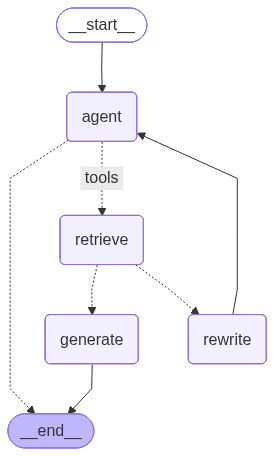

In [65]:
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

# Fifth, define functions for smooth application.

In [66]:
def agent_invoke(graph, question, config):
    """
    Invoke the workflow with user question, generate human-friendly metrics and answers.

    Args:
        graph: The current workflow
        question: The user input to invoke the workflow
        config: The holder of thread, memory, and LangFuse

    Returns:
        retriever_counter: how many times the retriever tool is called for this question
        rewrite_counter: how many times the question is rewritten, which indicates a failed retrieval
        final_message: the answer that can be shown to all audience
    """
    config["configurable"]["questions"].append(question)
    print("config", config)

    retriever_counter = 0
    rewrite_counter = 0
    final_message = ""

    inputs = {
        "messages":[
            ("user", question)
        ]
    }

    for output in graph.stream(inputs, config=config):
        for key, value in output.items():
            # For Agent node, output tool call information.
            if key == 'agent':
                ai_message = value['messages'][0]
                if ai_message.tool_calls:
                    print("Tool calls detected:")
                    for tool_call in ai_message.tool_calls:
                        print(f"Tool Name: {tool_call['name']}")
                        print(f"Arguments: {tool_call['args']}")
                        print(f"ID: {tool_call['id']}")
                else:
                    print("No tool calls in this AI message.")
                    final_message = final_message + value['messages'][0].content
            # For retrieve tool node, counter plus.
            elif key == 'retrieve':
                retriever_counter = retriever_counter + 1
            # For rewrite tool node, counter plus.
            elif key == 'rewrite':
                rewrite_counter = rewrite_counter + 1
            # For generate node, record the final human-friendly answer.
            elif key == 'generate':
                print("\n---END QUESTION---")
                final_message = final_message + value['messages'][0]
            else:
                pass
            print(final_message)
    return retriever_counter, rewrite_counter, final_message

In [67]:
def deal_with_single_question(logs, graph, question, config):
    """
    Deal with the workflow inputs and outputs, push them into local logging system.

    Args:
        logs: the list to store key information and metrics for the whole thread
        graph: The current workflow
        question: The user input to invoke the workflow
        config: The holder of thread, memory, and LangFuse
    """
    # Get the current date and time for time stamp.
    invoke_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
    retriever_counter, rewrite_counter, final_message = agent_invoke(graph, question, config)
    thread_id = config['configurable']['thread_id']
    row =  [thread_id, invoke_datetime, question, final_message, retriever_counter, rewrite_counter]
    logs.append(row)

# Case Test

In [75]:
# Put LangFuse Handler when the workflow is invoked.

# langfuse_handler = CallbackHandler()

config = {"configurable": {"thread_id": "client-help", "questions": []}, "model_config": {"n": 1 }}
logs = []

In [76]:
deal_with_single_question(logs, graph, "Hi, I'm Alexandra.", config)

config {'configurable': {'thread_id': 'client-help', 'questions': ["Hi, I'm Alexandra."]}, 'model_config': {'n': 1}}
---CALL AGENT---
No tool calls in this AI message.
Hello Alexandra! How can I assist you today?


In [77]:
deal_with_single_question(logs, graph, "What does Xiaoshi Lu like in spare time?", config)


config {'configurable': {'thread_id': 'client-help', 'questions': ["Hi, I'm Alexandra.", 'What does Xiaoshi Lu like in spare time?']}, 'model_config': {'n': 1}}
---CALL AGENT---
Tool calls detected:
Tool Name: retrieve_job_seeker
Arguments: {'query': 'Xiaoshi Lu hobbies'}
ID: call_4NBPrFUdOuvJwjLAF2DiuZdP

---CHECK RELEVANCE---
Original question:
 What does Xiaoshi Lu like in spare time?
---DECISION: DOCS RELEVANT---

---GENERATE---
Original question:
 What does Xiaoshi Lu like in spare time?

---END QUESTION---
Xiaoshi Lu enjoys watching old-style movies, listening to pop music in unfamiliar languages, swimming, and hiking in her spare time.


In [78]:
deal_with_single_question(logs, graph, "Tell me something about Xiaoshi Lu's relationship with Dima Bilan", config)

config {'configurable': {'thread_id': 'client-help', 'questions': ["Hi, I'm Alexandra.", 'What does Xiaoshi Lu like in spare time?', "Tell me something about Xiaoshi Lu's relationship with Dima Bilan"]}, 'model_config': {'n': 1}}
---CALL AGENT---
Tool calls detected:
Tool Name: retrieve_job_seeker
Arguments: {'query': 'Xiaoshi Lu relationship with Dima Bilan'}
ID: call_EiLUs97Yhbrx4NGXQmPosKtG

---CHECK RELEVANCE---
Original question:
 Tell me something about Xiaoshi Lu's relationship with Dima Bilan
---DECISION: DOCS NOT RELEVANT---

---TRANSFORM QUERY---
Original question:
 Tell me something about Xiaoshi Lu's relationship with Dima Bilan
Transformed question:
 What is the nature of the relationship between Xiaoshi Lu and Dima Bilan?

---CALL AGENT---
No tool calls in this AI message.
There is no information available about any relationship between Xiaoshi Lu and Dima Bilan. It seems they may not have any known connection. If you have any other questions or need information on a diff

In [79]:
deal_with_single_question(logs, graph, "What job advertisement do you have?", config)

config {'configurable': {'thread_id': 'client-help', 'questions': ["Hi, I'm Alexandra.", 'What does Xiaoshi Lu like in spare time?', "Tell me something about Xiaoshi Lu's relationship with Dima Bilan", 'What job advertisement do you have?']}, 'model_config': {'n': 1}}
---CALL AGENT---
Tool calls detected:
Tool Name: retrieve_job_seeker
Arguments: {'query': 'job advertisement'}
ID: call_7zOzkKOoI0hU8dMVhSTdLxEN

---CHECK RELEVANCE---
Original question:
 What job advertisement do you have?
---DECISION: DOCS RELEVANT---

---GENERATE---
Original question:
 What job advertisement do you have?

---END QUESTION---
I have two job advertisements:

1. **Customer Service Representative - National Call Centre**
   - Location: Melbourne, Hawthorn
   - Responsibilities include taking inbound and outbound calls, coordinating with field technicians, and providing proactive communication to customers.
   - Requirements include recent call centre or customer service experience, excellent data entry and 

In [80]:
deal_with_single_question(logs, graph, "Is Xiaoshi Lu eligible for any role in your database?", config)

config {'configurable': {'thread_id': 'client-help', 'questions': ["Hi, I'm Alexandra.", 'What does Xiaoshi Lu like in spare time?', "Tell me something about Xiaoshi Lu's relationship with Dima Bilan", 'What job advertisement do you have?', 'Is Xiaoshi Lu eligible for any role in your database?']}, 'model_config': {'n': 1}}
---CALL AGENT---
Tool calls detected:
Tool Name: retrieve_job_seeker
Arguments: {'query': 'Xiaoshi Lu skills and experience'}
ID: call_evoA90K46RQkW8aZou60LgFH
Tool Name: retrieve_job_seeker
Arguments: {'query': 'job advertisement'}
ID: call_ztpvchpkjVPkJP7zY7VKckGE

---CHECK RELEVANCE---
Original question:
 Is Xiaoshi Lu eligible for any role in your database?
---DECISION: DOCS NOT RELEVANT---

---TRANSFORM QUERY---
Original question:
 Is Xiaoshi Lu eligible for any role in your database?
Transformed question:
 Does Xiaoshi Lu meet the qualifications for any positions listed in your database?

---CALL AGENT---
No tool calls in this AI message.
Based on Xiaoshi Lu's

In [81]:
# Transform log to dataframe.
log_df = pd.DataFrame(logs)
log_df.columns = ["ThreadID", "DateTime", "OriginalQuestion", "FinalAnswer", "RetrieverCount", "RewriteCount"]

# Construct the filename with the datetime suffix and thread id.
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
thread_id = log_df["ThreadID"].loc[0]
filename = f"client-help-logs/{thread_id}_{current_time}.csv"

# Save the DataFrame to CSV file.
log_df.to_csv(filename, index=False) 
print(f"Save log for this thread to {filename}")

Save log for this thread to client-help-logs/client-help_20251025_214423.csv


In [82]:
# Calculate Retrieval Relevant Percentage of the thread.
retriever_metrics = pd.DataFrame(log_df[["RetrieverCount", "RewriteCount"]].sum())
total_retriever_count = retriever_metrics.loc['RetrieverCount', 0]
total_rewrite_count = retriever_metrics.loc['RewriteCount', 0]
total_accuracy_count = total_retriever_count - total_rewrite_count

if total_retriever_count > 0:
    print("The Retrieval Relevant Percentage of this thread is:", f"{total_accuracy_count/total_retriever_count:.2f}")
else:
    print("No retriever was used in this thread.")

The Retrieval Relevant Percentage of this thread is: 0.50
